# Eye State Recognition Using Alpha Waves

## Loading & Inspecting Dataset   

In [1]:
import dataset
import numpy as np
from mne.preprocessing import ICA
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
from scipy.signal import welch
from detecta import detect_peaks 
import warnings
import mne
warnings.filterwarnings("ignore")

# define the dataset instance
eeg_dataset = dataset.AlphaWaves() 
eeg_dataset.subject_list 

C:\Users\YOUSSEF\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Filtering Dataset Using Bandpass Filter

In [2]:
subjects_Filtered_data = list()

filter_type = 'bandpass'  
low_cutoff = 8  
high_cutoff = 12  
filter_order = 6

for i in eeg_dataset.subject_list:
    raw = eeg_dataset._get_single_subject_data(i).filter(l_freq=low_cutoff, h_freq=high_cutoff, picks='eeg', filter_length='auto',
           l_trans_bandwidth='auto', h_trans_bandwidth='auto', phase='zero',
           fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),verbose = False)

    subjects_Filtered_data.append(raw)


## Denoising Using ICA 

### Inspection IC of Each Subject 

In this step, we will inspect the IC of each subject individually, and then accept or reject components based on visually inspection. We will mention the components that will be reject for each subject in `exclude_list`. 

In [3]:
exclude_list = [[0,3,4,6,11,14,15],[15,9,8],[0,1,3,5,9,10],[3,5,8,10],[0,2,4,6,13,11],
                [1,6,8,10,11,12,14],[1,2,3,4,5],[5,11,13,14],[0,2,3,5,11,14],[6,9,11,13,15],[12,7,2,0,3,6,5]
                ,[1,2,3,7],[0,1,3,6,10,12],[1,4,7,10,15,6],[0,2,3,5,12,13],[7,8,10,12,13],[5,6,7,10,12],[0,1,2,6,8,10,11,12]
                ,[0,2,4]] # by inspection 



assert len(eeg_dataset.subject_list) == len(exclude_list)

> Note: This exclude list can be used if you have followed the same defined `random_state` and `n_components` provided to `ica` object.  

In [4]:
def plot_subject_data(ica,subject_index,no_comp):
    raw_copy = subjects_Filtered_data[subject_index].copy()
    eeg_picks = raw_copy.pick_types(eeg = True)
    scalings = {'eeg': 15}
    eeg_picks.plot(scalings = scalings);
    ica.fit(raw_copy)
    ica.plot_components()
    ica.plot_properties(inst=raw_copy,picks = range(no_comp),verbose = False);
    return raw_copy

#### Example of Inspection  

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


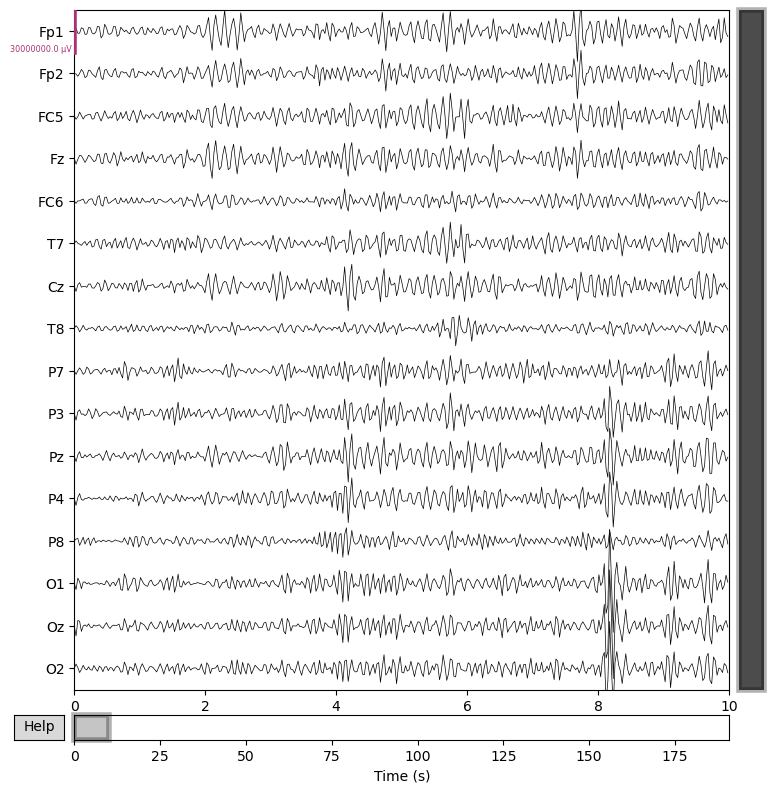

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 2.4s.


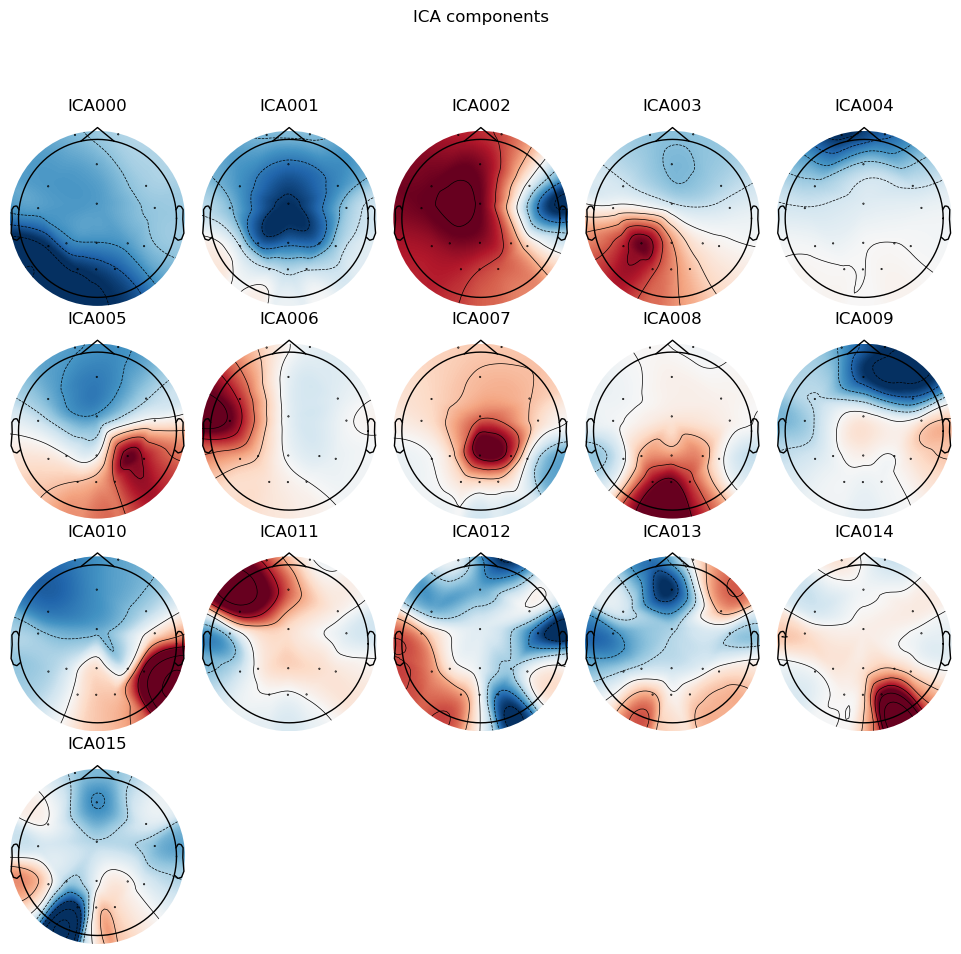

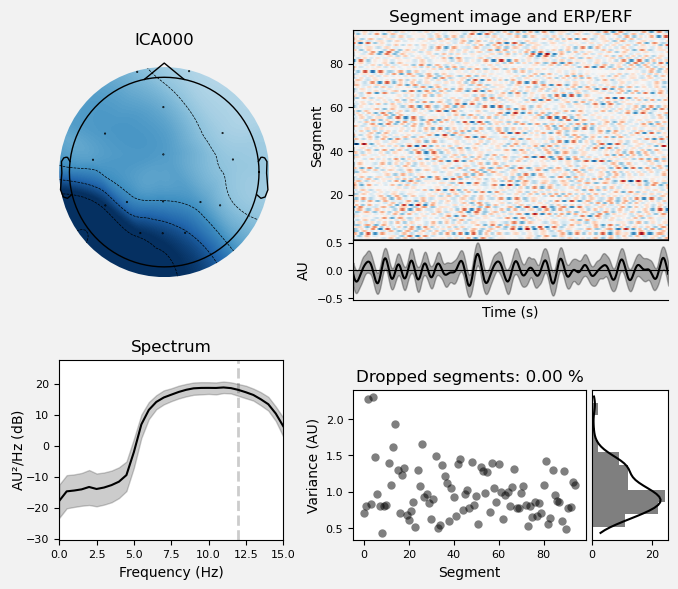

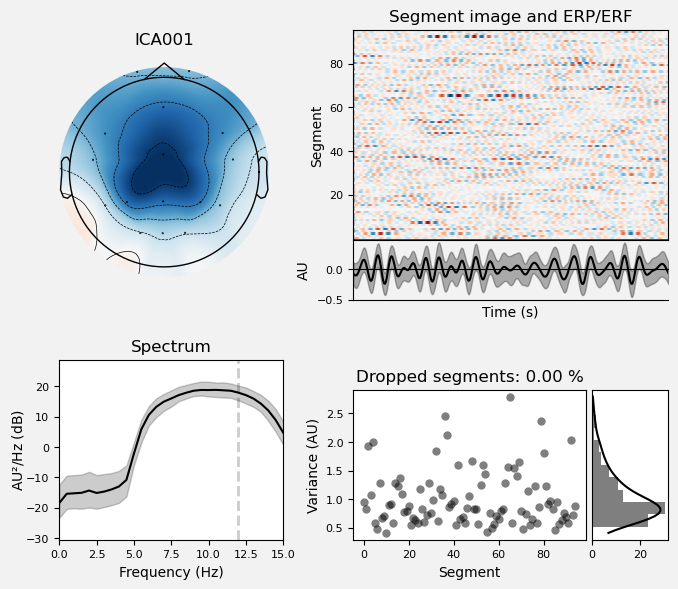

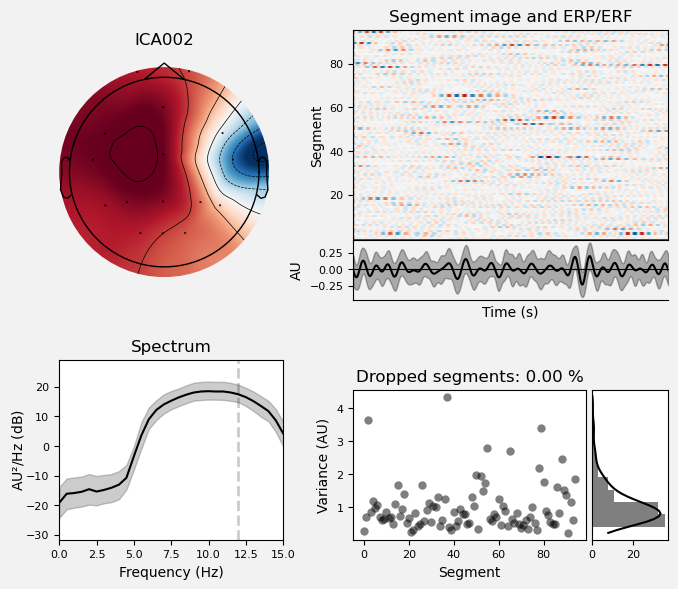

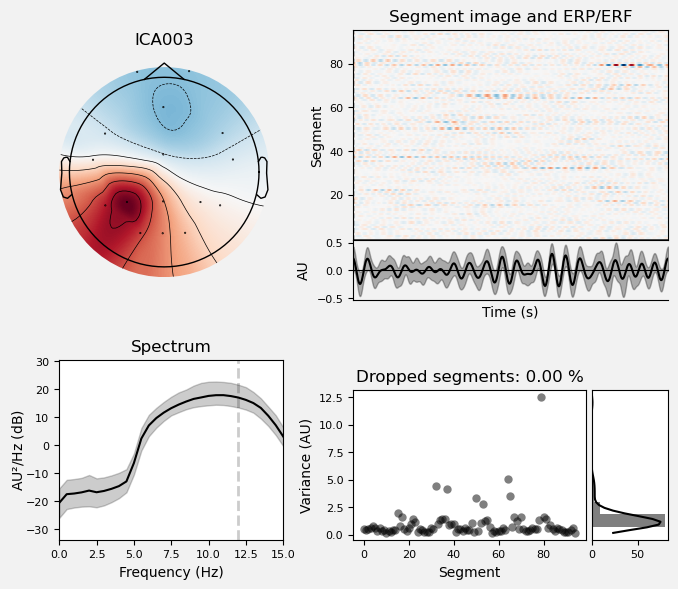

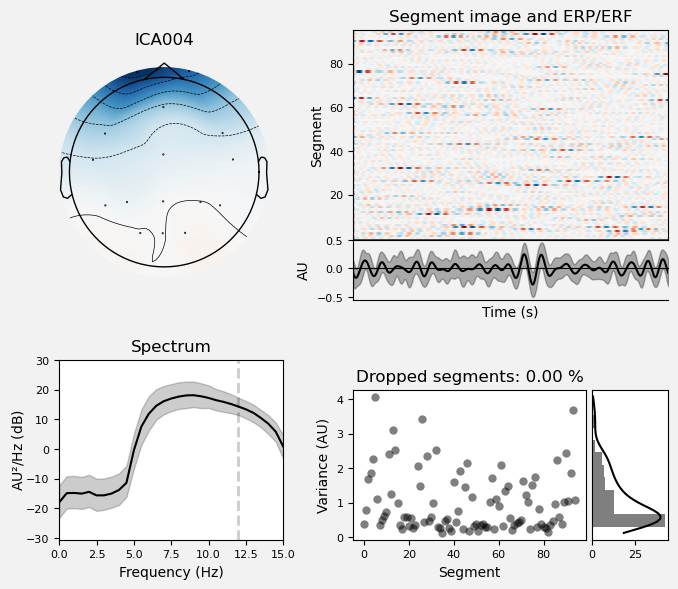

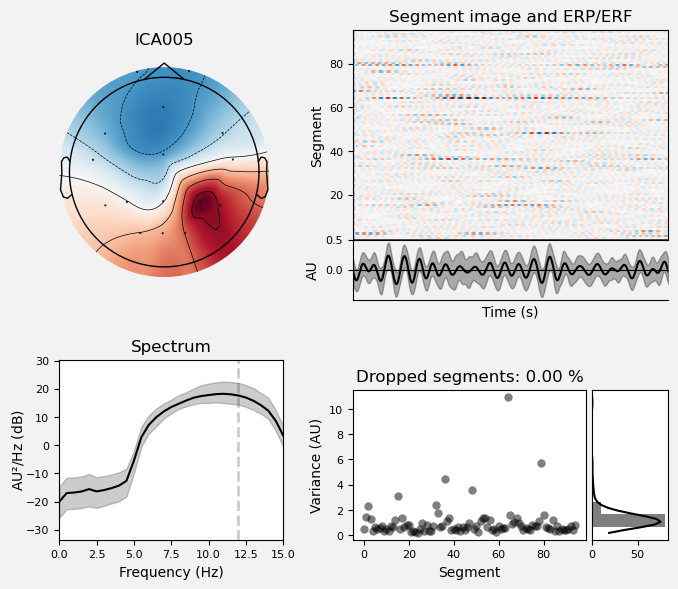

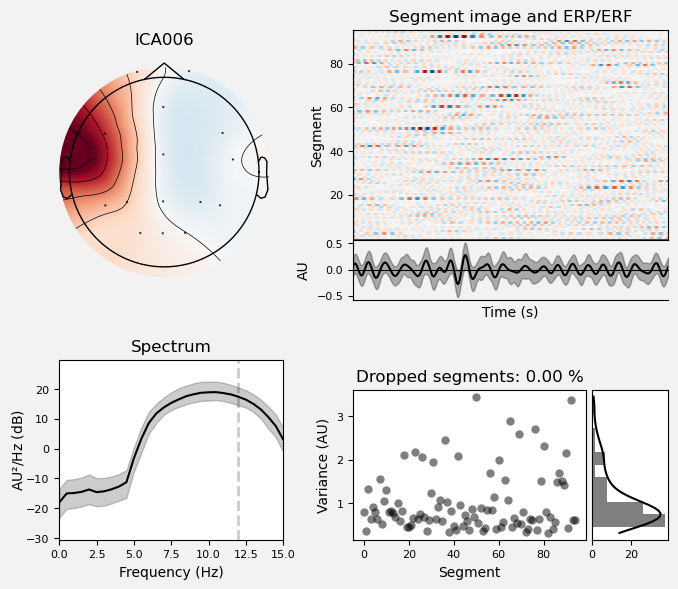

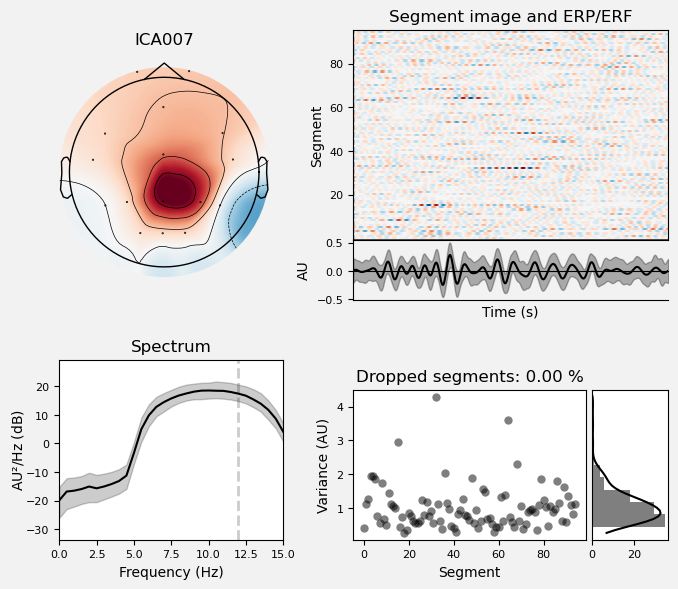

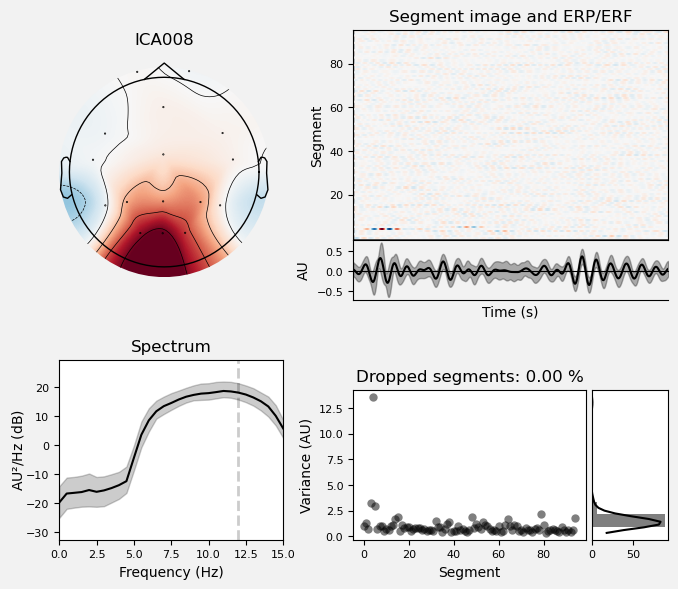

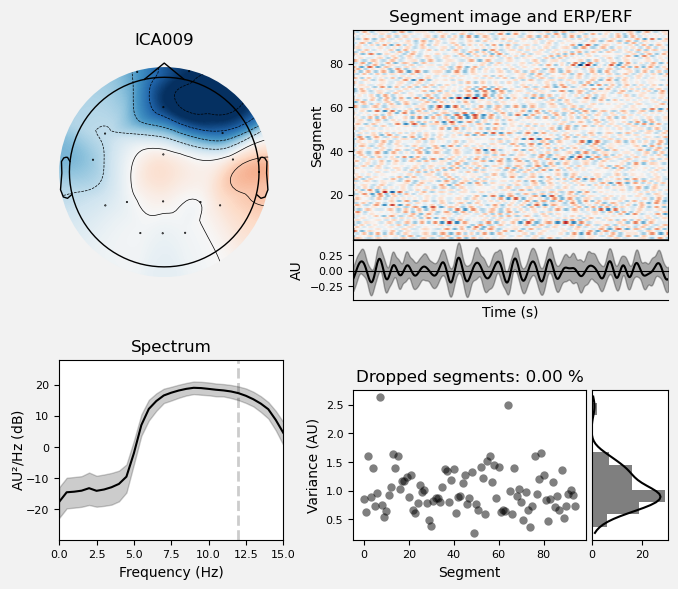

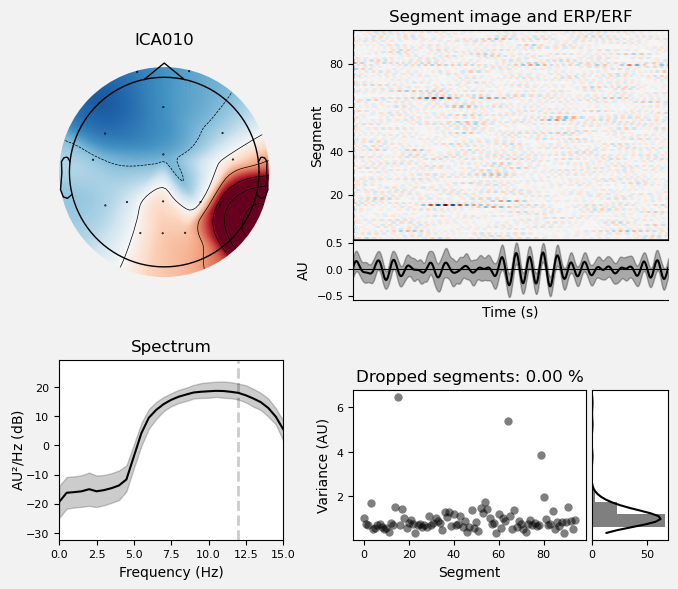

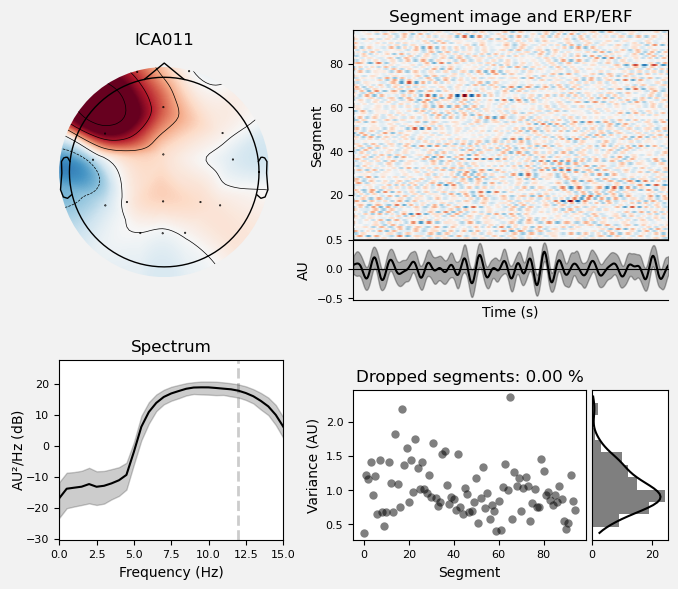

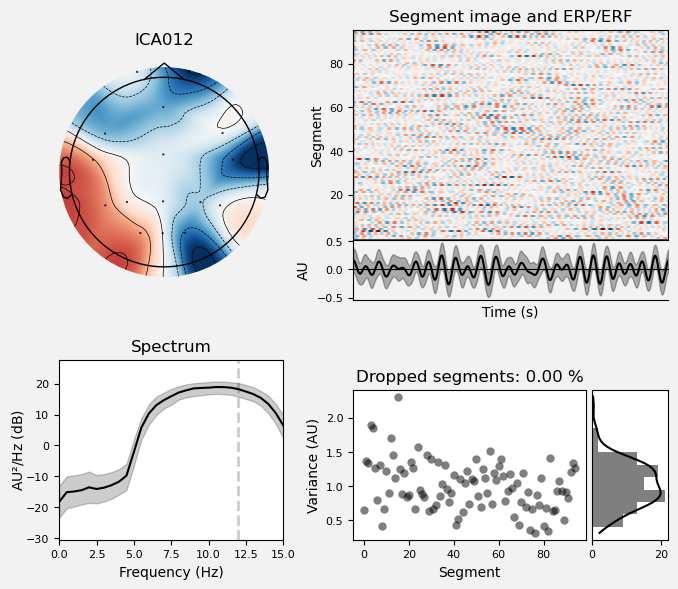

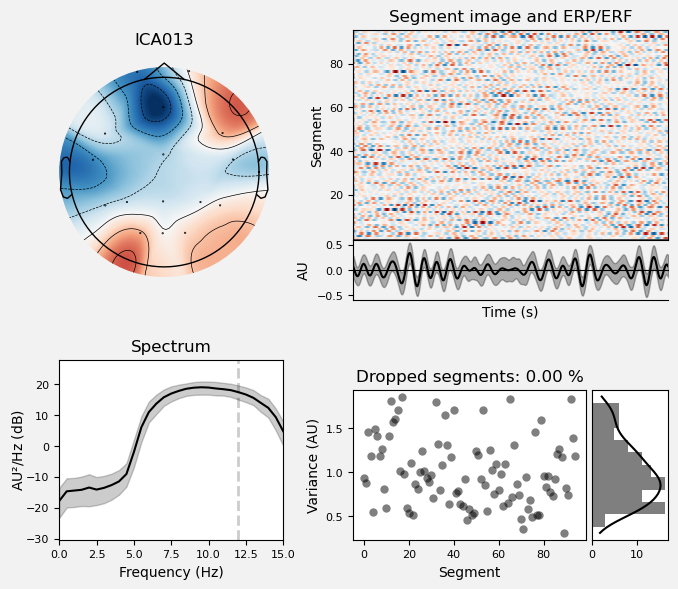

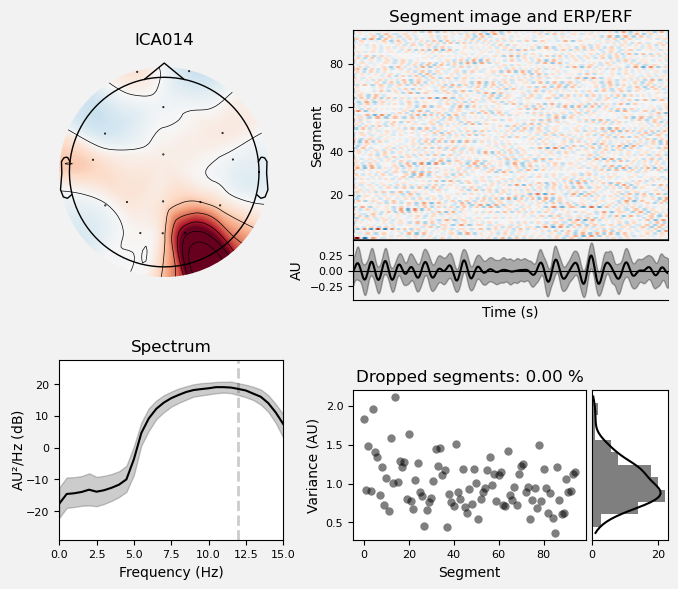

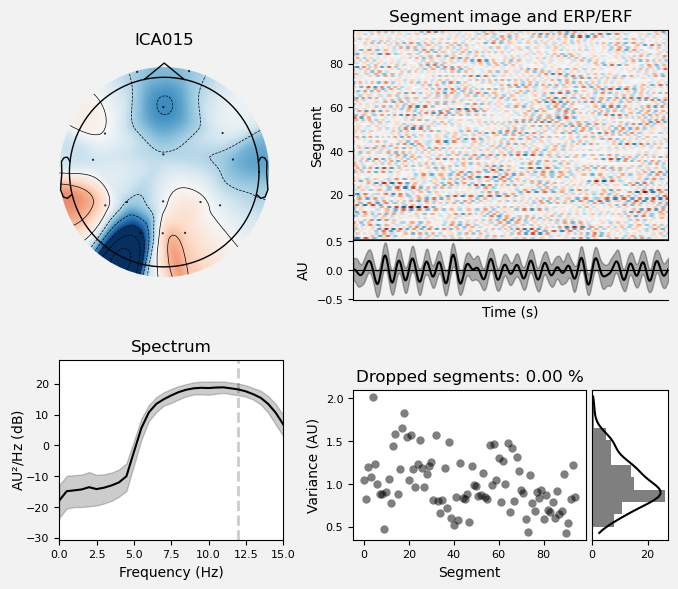

In [5]:
subject_index = 3
no_comp = 16
ica = ICA(n_components=no_comp, random_state=1)
raw_copy = plot_subject_data(ica,subject_index,no_comp)

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 4 ICA components
    Projecting back using 16 PCA components
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


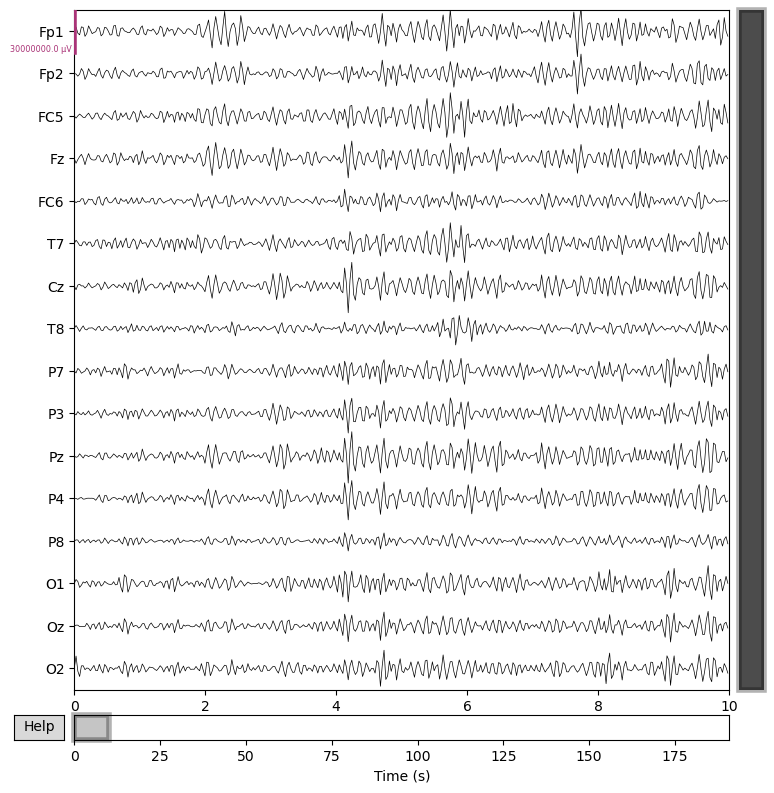

In [6]:
ica.exclude = exclude_list[subject_index]
ica.apply(raw_copy)
eeg_picks = raw_copy.pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings);

### Removing Artifacts 

In [7]:
cleaned_subjects_data = []
for i, raw in enumerate(subjects_Filtered_data):
    ica = ICA(n_components=16, random_state=1)
    cleaned_data = raw.copy()
    ica.fit(cleaned_data,verbose = False)
    ica.exclude = exclude_list[i]
    ica.apply(cleaned_data,verbose = False)
    cleaned_subjects_data.append(cleaned_data)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


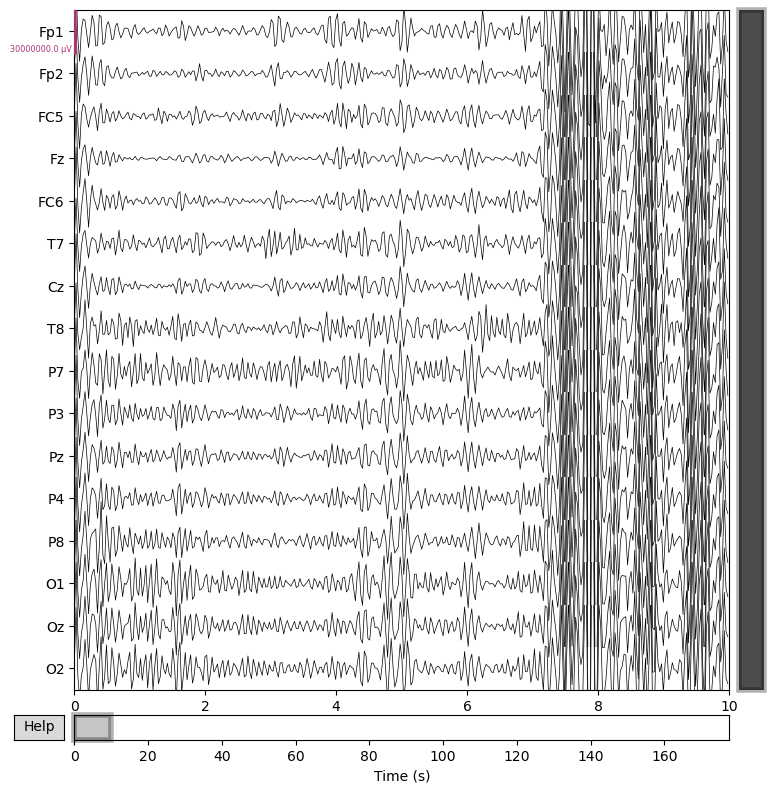

In [8]:
# plotting the channels of the subject 3 before applying ICA 
eeg_picks = subjects_Filtered_data[17].pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings);

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


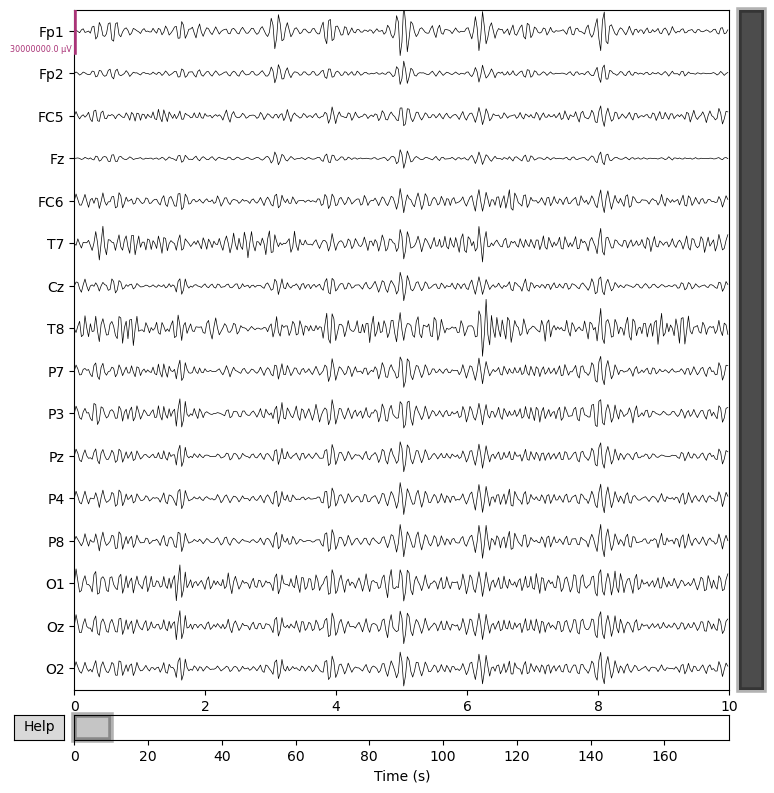

In [9]:
# plotting the channels of the subject 3 after applying ICA 
eeg_picks = cleaned_subjects_data[17].pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings);

## resampling & Epoching 

In [10]:
# let's consider just the first subject 
first_subject = cleaned_subjects_data[0].copy()
first_subject.resample(sfreq=128, verbose=False);

In [11]:
events = mne.find_events(raw=first_subject, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(first_subject , events, event_id, tmin=2.0, tmax=8.0, baseline=(None,None),
                    verbose=False)
# epochs.load_data().pick_channels(["Oz"]);
epochs.load_data()
X_closed = epochs['closed'].get_data()
X_closed.shape


Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped


(5, 17, 769)

### Estimate Averaged Spectra for Each Condition

In [12]:
X_closed = epochs['closed'].get_data()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], axis=2) 
# S_closed = np.mean(S_closed, axis=0).squeeze()
S_closed[0][0].shape

(129,)

In [13]:
X_opened = epochs['open'].get_data()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], axis=2)
# S_opened = np.mean(S_opened, axis=0).squeeze()
print(S_opened.squeeze().shape)
print(f.shape)
S_opened[0][0].shape

(5, 17, 129)
(129,)


(129,)

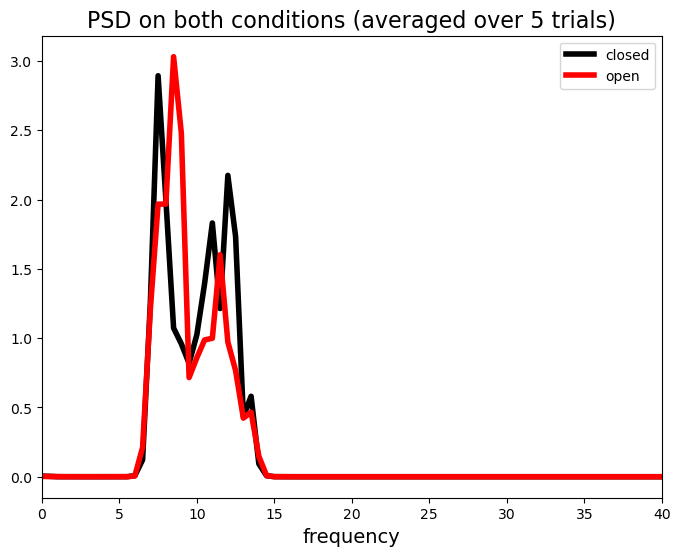

In [14]:
fig = plt.figure(facecolor='white', figsize=(8, 6))
plt.plot(f, S_closed[0][0], c='k', lw=4.0, label='closed')
plt.plot(f, S_opened[0][0], c='r', lw=4.0, label='open')
plt.xlim(0, 40)
plt.xlabel('frequency', fontsize=14)
plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)
plt.legend()
plt.show();

### Applying Resampling and Epoching to all Subjects 

In [15]:
missing_data_object = cleaned_subjects_data[17]
cleaned_subjects_data.remove(missing_data_object)
epochs_list = list()
for subject in cleaned_subjects_data:
    subject_copy = subject.copy()
    subject_copy.resample(sfreq=128, verbose=False);
    events = mne.find_events(raw=subject_copy,stim_channel = 'stim', shortest_event=1, verbose=False)
    event_id = {'closed': 1, 'open': 2}
    epochs = mne.Epochs(subject_copy , events, event_id, tmin=2.0, tmax=8.0, baseline=(None,None),
                        verbose=False)
    epochs_list.append(epochs)

> While epoching the data, we have found that there are some missing data regarding subject **18**. So, we have excluded it.

In [16]:
print(missing_data_object.ch_names)

['Fp1', 'Fp2', 'FC5', 'Fz', 'FC6', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


## Feature Extraction 

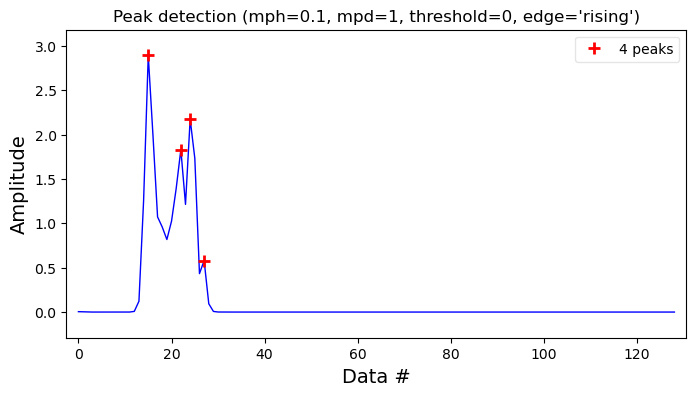

[ 7.5 11.  12.  13.5]
[2.89382696 1.83148381 2.17468125 0.58055569]


In [17]:
ind = detect_peaks(S_closed[0][0],mph = 0.1,show=True); 
print(f[ind])
print(S_closed[0][0][ind])

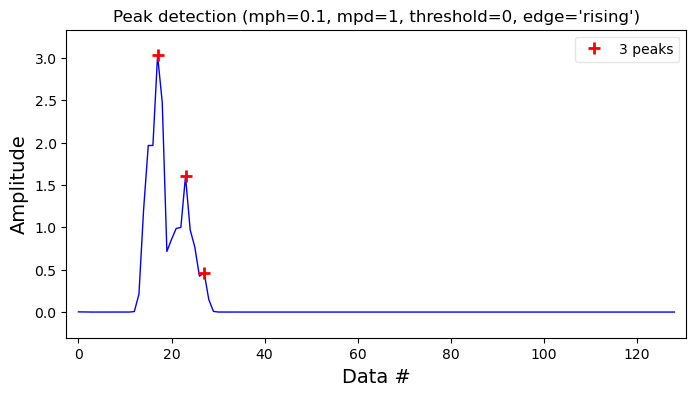

[ 8.5 11.5 13.5]
[3.03117798 1.60202673 0.46594414]


In [18]:
ind = detect_peaks(S_opened[0][0],mph = 0.1,show=True); 
print(f[ind])
print(S_opened[0][0][ind])

### Some Facility Functions 

In [19]:
def get_features(x_values,signal,mph): 
    """ extract some peaks from a transformed data at features.
            args:
                x_values: x-coordinate of the signal (i.e.,time difference & frequency)
                y_values: the transformed data (FFT, PSD or Autocorrelation values) 
                mph: the minimum peak height 
            
            return: 
                (peaks_x + peaks_y): a list of x and y coordinates concatenated 
    """
    indices_peaks = detect_peaks(signal,mph = mph) 
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks],signal[indices_peaks])
    return peaks_x + peaks_y 

In [20]:
def get_first_n_peaks(x,y,no_peaks = 5): 
    """ Extract the first "n_peaks" peaks of the transformed signal. If the number of peaks
        is not sufficient it fills the rest with zeros. 
        
        args:
            x: the x-coordinate of the transformed signal (time difference or frequency)
            y: the transformed signal values
            n_peaks: the number of peaks to extract from the signal
    """
    x_,y_ = list(x),list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks],y_[:no_peaks]
    else: # filling the rest values with zeros if it's not sufficient
        missing_no_peaks = no_peaks - len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

In [29]:
closed_eye_signals = []
# for epochs in epochs_list:
epochs_list[0].load_data()
X_closed = epochs_list[0]['closed'].get_data()
for signal in X_closed:
    signal = list() # features list to which we are going to append our extracted features 
    for channel in signal:
        # PSD features 
        print(channel.shape)
        f, S_closed = welch(channel, fs=epochs.info['sfreq'])
        PSD_features = get_features(f, S_closed,0.1) # 0.1 --> by inspection 
        # mean feature 
        mean_val = np.mean(channel)
        # # variance feature
        variance_val = np.var(channel)